# Floor plan auto-completion dataset

## Import dataset

In [1]:
import os
import pandas as pd
from geopandas import GeoDataFrame as gdf

path = r'C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0'
geometries = pd.read_csv(os.path.join(path, 'geometries.csv'))
geometries = gdf(geometries)
geometries

,apartment_id,site_id,building_id,plan_id,floor_id,unit_id,area_id,unit_usage,entity_type,entity_subtype,geometry,elevation,height
0,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619311.0,RESIDENTIAL,area,BATHROOM,POLYGON ((-2.7337844078265210 4.07980744083215...,0.0,2.6
1,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619303.0,RESIDENTIAL,area,LIVING_ROOM,POLYGON ((5.8278988701887320 7.816876723402971...,0.0,2.6
2,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619322.0,RESIDENTIAL,area,ROOM,POLYGON ((6.7557107205191187 2.413369594812586...,0.0,2.6
3,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619310.0,RESIDENTIAL,area,KITCHEN,POLYGON ((3.5821200013910017 5.140461688341117...,0.0,2.6
4,3c3b1d6ca8b4b9092480b8c75f9eaa81,210,399,1054,1588,7300.0,619312.0,RESIDENTIAL,area,ROOM,POLYGON ((3.0141380455489282 4.182056855151666...,0.0,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255900,NaN,855,1810,5103,8035,NaN,NaN,PUBLIC,opening,DOOR,POLYGON ((-1.4298320523458550 3.33190316001201...,14.5,2.0
3255901,NaN,855,1810,5103,8035,NaN,NaN,PUBLIC,opening,ENTRANCE_DOOR,POLYGON ((-3.5023200042238898 3.33190316001201...,14.5,2.0
3255902,NaN,855,1810,5103,8035,NaN,NaN,PUBLIC,opening,WINDOW,POLYGON ((0.5283550488528448 5.786336039980051...,15.0,1.9
3255903,NaN,855,1810,5103,8035,NaN,NaN,PUBLIC,opening,WINDOW,POLYGON ((-3.6279253346407394 5.80601415589792...,15.0,1.9


## Meta analysis and filtering

Below shows the distribution of entity subtypes; the logarithmic scale spreads it more conveniently. Obviously, there are frequent occurring subtypes such as WALL, KITCHEN, ROOM, BATHROOM, but also subtypes that do nearly occur (<100 times in the whole dataset) such as TEACHING ROOM, WATER SUPPLY, COUNTER ROOM, ARCADE, RECEPTION ROOM.

In [2]:
TYPES = geometries.groupby(['entity_type']).count().sort_values(by = ['geometry'])['geometry'].to_frame()
SUBTYPES = geometries.groupby(['entity_subtype']).count().sort_values(by = ['geometry'])['geometry'].to_frame()

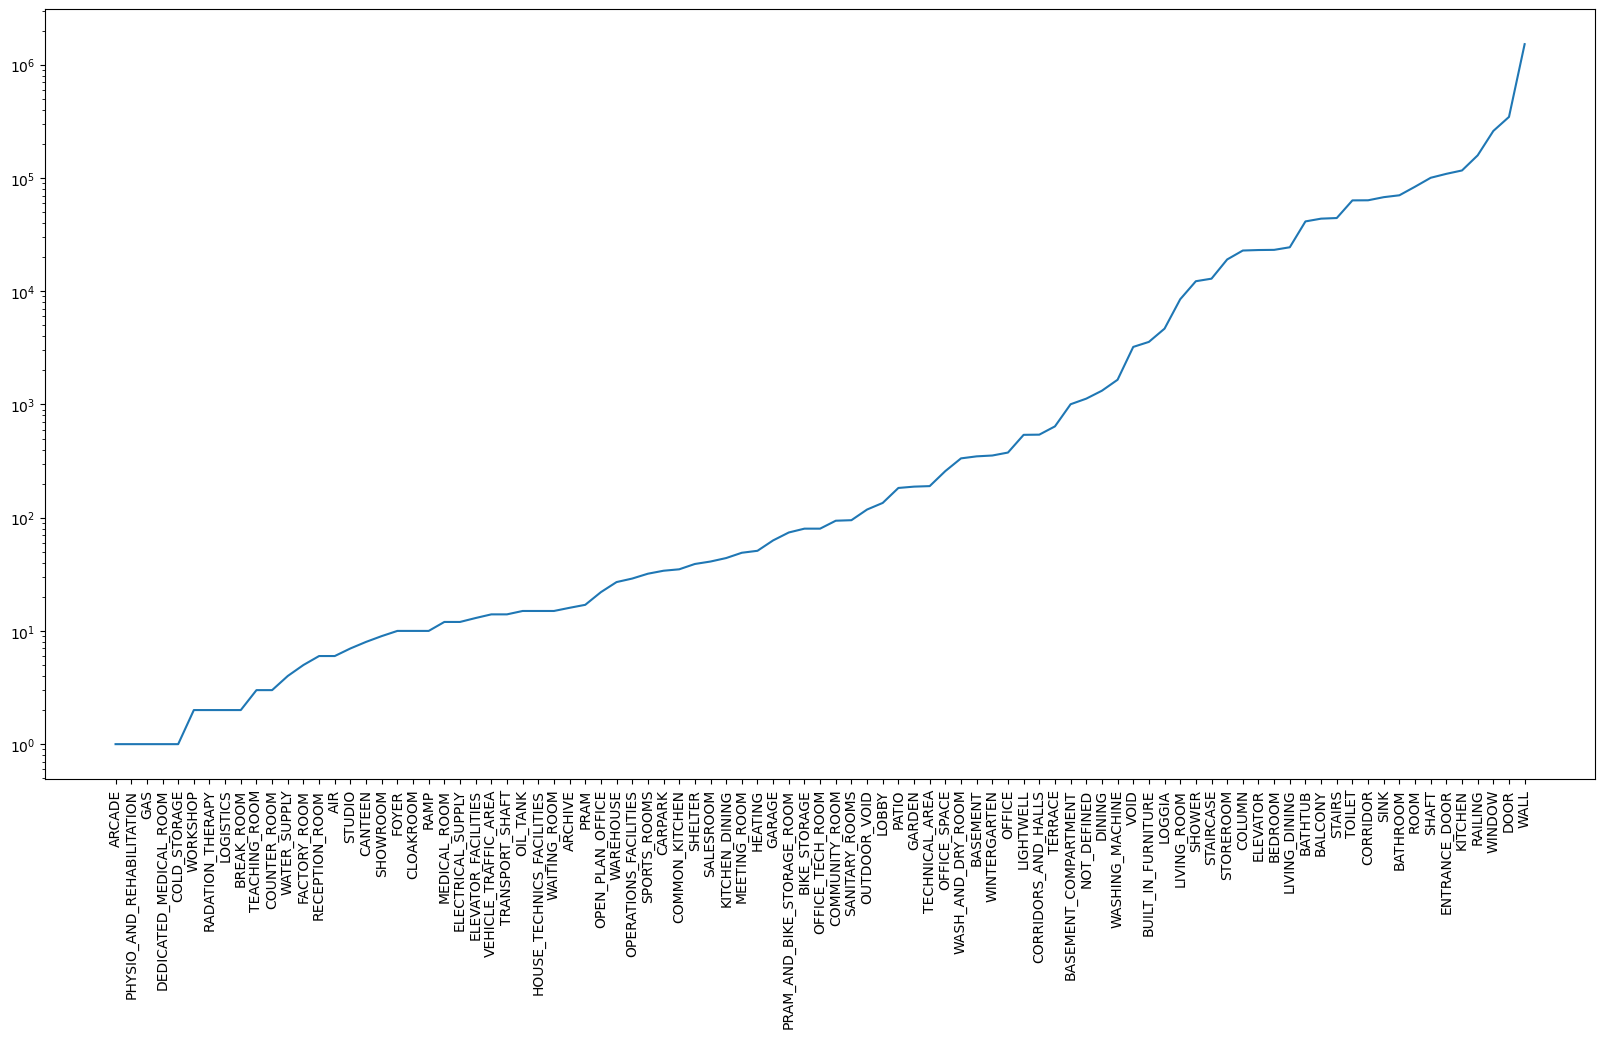

In [3]:
import matplotlib.pyplot as plt

FS = 10
fig, ax = plt.subplots(1,1,figsize=(FS*2, FS))

ax.plot(SUBTYPES)
ax.set_yscale('log') # set to logscale for interpretability
ax.tick_params(axis='x', labelrotation = 90)

### Filter on residential

Check typologies

In [4]:
TYPOLOGIES = geometries.groupby(['unit_usage']).count().sort_values(by = ['geometry'])['geometry'].to_frame()
TYPOLOGIES

,geometry
unit_usage,
JANITOR,38
PLACEHOLDER,82
COMMERCIAL,16500
PUBLIC,588501
RESIDENTIAL,2650784


Filter the dataset

In [5]:
from utils import SUBTYPES_TO_REMOVE

# filter on residential
temp_geometries = geometries[geometries.unit_usage == "RESIDENTIAL"].reset_index()
valid_floor_ids = set(temp_geometries.floor_id)
residential_geometries = geometries[geometries['floor_id'].isin(valid_floor_ids)].reset_index()

# remove mixtures
wrong_geometries = residential_geometries[residential_geometries['entity_subtype'].isin(set(SUBTYPES_TO_REMOVE))].reset_index()
correct_floor_ids = valid_floor_ids - set(wrong_geometries.floor_id)
correct_geometries = residential_geometries[residential_geometries['floor_id'].isin(correct_floor_ids)].reset_index()

print(f'Number of filtered floors: {len(set(correct_geometries.floor_id))}')
print(f'Number of room categories: {len(set(correct_geometries.entity_subtype))}')

Number of filtered floors: 13451
Number of room categories: 64


We reduce the amount of categories by grouping similar subtypes together. The mapping can be found in `utils`.

In [6]:
from utils import SUBTYPE_MAPPING

correct_geometries['entity_subtype_reduce'] = correct_geometries['entity_subtype'].map(SUBTYPE_MAPPING).fillna('Remaining')

In [7]:
SUBTYPES_REDUCED = correct_geometries.groupby(['entity_subtype_reduce']).count().sort_values(by = ['geometry'])['geometry'].to_frame()
SUBTYPES_NAMES = list(SUBTYPES_REDUCED.index)
SUBTYPES_NAMES.reverse()
SUBTYPES_NAMES

['Remaining',
 'Bathroom',
 'Kitchen-Dining',
 'Bedroom',
 'Corridor',
 'Stairs-Ramp',
 'Outdoor-Area',
 'Living-Room',
 'Basement',
 'Office',
 'Garage',
 'Warehouse-Logistics',
 'Meeting-Salesroom']

## Graph extraction

First, the necessary information is extracted from the geometry file.

In [8]:
def get_geometries_from_frame(floor_geoms_df):
    """
    Extracting geometry information from the corresponding frames.
    """

    areas, area_types = zip(
        *floor_geoms_df.query("entity_type == 'area'")[
            ["geometry", "entity_subtype_reduce"]
        ].values
    )
    doors = floor_geoms_df.query("entity_subtype == 'DOOR'")["geometry"].values
    front_doors = floor_geoms_df.query("entity_subtype == 'ENTRANCE_DOOR'")["geometry"].values
    walls = floor_geoms_df.query("entity_type == 'separator'")["geometry"].values

    return areas, area_types, doors, front_doors, walls

def floor_geometries_from_id(geoms_df, floor_id):
    """
    Filter from on specific floor id and convert geometry to Shapely readable form.
    """
    floor_geoms = geoms_df[(geoms_df.floor_id == floor_id)].reset_index(drop=True)
    floor_geoms.geometry = floor_geoms.geometry.apply(wkt.loads)

    return floor_geoms

Let's extract the necessary information from a random floor plan id and plot it.

In [27]:
from shapely import wkt

floor_id = 46637
floor_geoms_df = floor_geometries_from_id(correct_geometries, floor_id)
areas, area_types, doors, front_doors, walls = get_geometries_from_frame(floor_geoms_df)

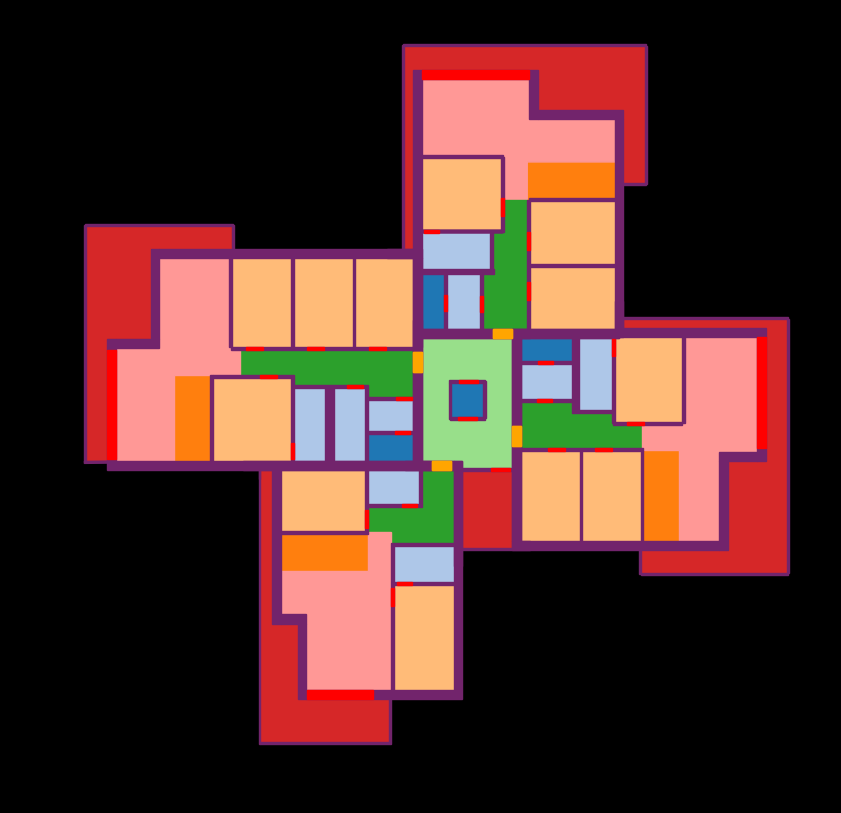

In [28]:
from plot import plot_floorplan, FS
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(FS, FS))
fig.set_facecolor('black')
ax.set_facecolor('black')
colorset = 'tab20'

plot_floorplan(ax, areas, area_types, doors=[doors, front_doors], walls=walls, linewidth=FS / 10, colorset=colorset, classes=SUBTYPES_NAMES)

The following function extracts the 'access' graph from the corresponding geometric information

In [29]:
from shapely.geometry import Polygon
import numpy as np
import torch
import networkx as nx
from itertools import combinations

# helper functions
def polygon_to_list(polygon: Polygon) -> list:
    return list(zip(*polygon.exterior.coords.xy))

def polygon_to_array(polygon: Polygon) -> np.array:
    return np.array(polygon_to_list(polygon))

# access graph extraction
def get_access_graph(areas, area_types, doors, front_doors, walls):

    # NODES
    area_nodes = {}
    for key, (area, area_type) in enumerate(zip(areas, area_types)):
        area_nodes[key] = {
            'geometry': polygon_to_array(area),
            'category': area_type,
            'centroid': torch.tensor(np.array([area.centroid.x, area.centroid.y]))
        }

    # EDGES
    edges = []
    for (i, v1), (j, v2) in combinations(enumerate(areas), 2):

        # Option 1: PASSAGE (direct access := no wall in between)
        if v1.distance(v2) < 0.04:
            edges.append([i, j, {'connectivity': 'passage', 'door-geometry': np.array([])}])

        # TODO: make [2, 3] more efficient; now it performs similar operations multiple times
        #   e.g., by computing door-room relations before the loop

        # Option 2: DOOR
        else:
            for door in doors:
                if door.distance(v1) < 0.05 and door.distance(v2) < 0.05:
                    edges.append([i, j, {'connectivity': 'door', 'door-geometry': polygon_to_array(door)}])
                else: continue

        # Option 3: FRONT DOOR
        for front_door in front_doors:
            if front_door.distance(v1) < 0.05 and front_door.distance(v2) < 0.05:
                edges.append([i, j, {'connectivity': 'entrance', 'door-geometry': polygon_to_array(front_door)}])
            else: continue

    # GRAPH
    graph = nx.Graph(walls = [polygon_to_array(wall) for wall in walls])
    graph.add_nodes_from([(u, v) for u, v in area_nodes.items()])
    graph.add_edges_from(edges)

    return graph

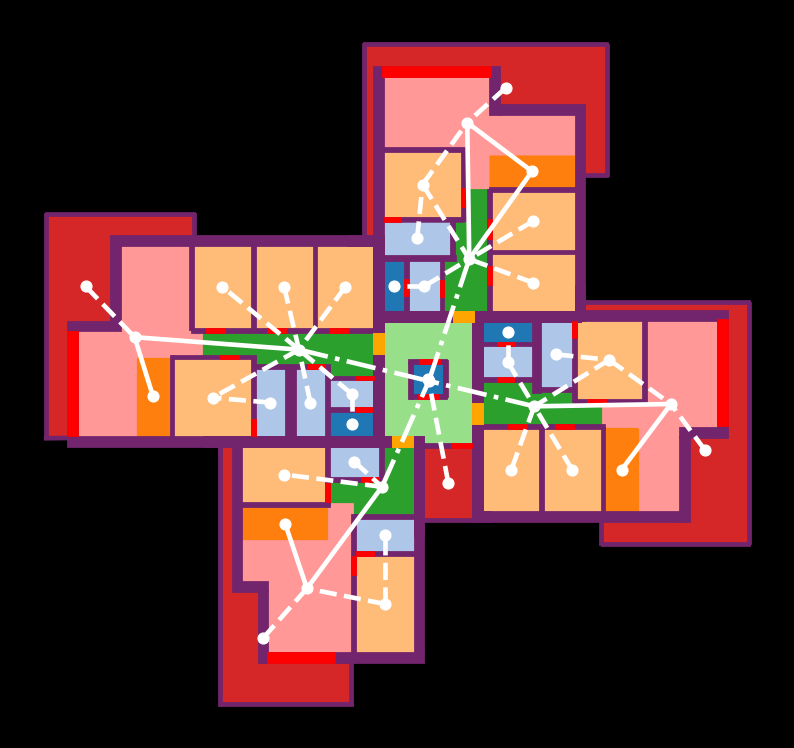

In [30]:
from plot import plot_graph
from matplotlib.cm import get_cmap

# get graph
graph = get_access_graph(areas, area_types, doors, front_doors, walls)

# figure
# setting
fig, ax = plt.subplots(1, 1, figsize=(FS, FS))
fig.set_facecolor('black')
cmap = get_cmap(colorset)
edge_colors = ['white']*4
_ = [ax.axis('off'), ax.axes.set_aspect('equal')]

# geometry
plot_floorplan(ax, areas, area_types, walls=walls, doors=[doors, front_doors], linewidth=FS/5, colorset=colorset)

# graph
pos = {n: np.array(graph.nodes[n]['centroid']) for n in graph.nodes}
colors = [np.array(cmap(SUBTYPES_NAMES.index(n))).reshape(1,4) for _, n in graph.nodes('category')]
plot_graph(graph, ax, c_node='white', dw_edge=True, c_edge=edge_colors, pos=pos, node_size=FS*6, edge_size=FS/3)

## Develop dataset

In [ ]:
import torch_geometric as pyg
from tqdm.auto import tqdm

for floor_id in tqdm(list(correct_floor_ids)):

    path_graph = os.path.join(path, 'graphs', f'{floor_id}.pickle')
    if os.path.exists(path_graph): continue  # don't do the same computation twice

    # get geometry information
    floor_geoms_df = floor_geometries_from_id(correct_geometries, floor_id)
    areas, area_types, doors, front_doors, walls = get_geometries_from_frame(floor_geoms_df)

    # access graph extraction
    graph = get_access_graph(areas, area_types, doors, front_doors, walls)
    graph_pyg = pyg.utils.from_networkx(graph)

    torch.save(graph_pyg, os.path.join(path, 'graphs', f'{floor_id}.pickle'))

  0%|          | 0/13451 [00:00<?, ?it/s]